In [25]:
import scipy
from scipy.interpolate import CubicSpline as CubicSpline
from scipy.interpolate import interp1d as interp1d
import pandas as pd
import numpy as np
#интерполяция
from scipy.interpolate import interp1d
#Рисование графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
#Старый метод
# data= pd.read_excel('nasdaq-composite.xlsx')
# data.columns=['date','value']
# data

In [3]:
data= pd.read_csv('Nasdaq_compose_Yahoo.csv')

#Выбираем нужные столбцы
data=data[['Date', 'Adj Close']]
data.columns=['date', 'value']

In [4]:
def slice_data(df, slice_period):
    return df.copy()[::slice_period].reset_index(drop=True)

In [19]:
slice_period=7
# Прореживаем данные и сортируем по дате
df=slice_data(data.sort_values(by='date'),slice_period) 

# Нормализуем данные по нужному периоду
# df['value']=df['value'].apply(lambda x: x/df.iloc[period_num].value)
# df.iloc[period_num]['date']

# Преобразуем в формат времени
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,date,value
0,1990-01-02,459.299988
1,1990-01-11,448.899994
2,1990-01-22,431.899994
3,1990-01-31,415.799988
4,1990-02-09,428.799988
...,...,...
1143,2021-10-04,14255.480469
1144,2021-10-13,14571.639648
1145,2021-10-22,15090.200195
1146,2021-11-02,15649.599609


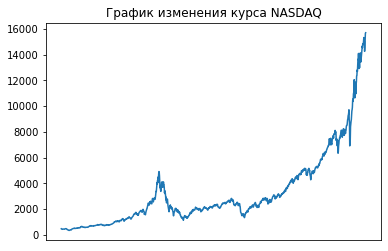

In [6]:
plt.plot(df['date'], df['value'])
plt.title('График изменения курса NASDAQ');
plt.xticks([])
plt.show()

In [7]:
# # Вводим вместо y разницу между ними
# x=x[1:]
# y=np.diff(y)
# step=.05
# xx = np.arange(1, data_length+step, step=step)
# # xx = np.linspace(x.min(), x.max(), num=round(data_length/step), endpoint=True)
# spline = CubicSpline(x, y, bc_type='clamped')
# yy=spline(xx)
# ww=np.diff(yy)
# plt.plot(xx[1:],ww**2)

In [22]:
def get_arange(length, step):
    return np.arange(1, length+step, step=step)

def deriv_spline(spline, n):
    # Находим производные сплайна порядка 0-3
    pp=[]
    for i in range(n):
        pp.append(spline.derivative(i))
    return pp

def calc_spline_values(xx, pp):
    # Вычисляем значения для производных сплайна
    ppf=[]
    for i in range(len(pp)):
        ppf.append(pp[i](xx))
    return ppf

def interpolate(ppf, step):
    # Задаем интервалы для интерполяции
    t=np.arange(1, ppf[0].shape[0]+1)
    pp1f_y=get_arange(ppf[0].shape[0], step=step)
    # Производим интерполяцию
    interp1=lambda x: interp1d(t, x, kind='cubic', fill_value="extrapolate")(pp1f_y) # нужен ли параметр fill_value
    deriv=[]
    for i in range(len(ppf)):
        deriv.append(interp1(ppf[i]))
    return deriv

def get_phase_portrait(x, y, step_spline=0.05,step_deriv=.01, deriv_num=4):
    #Высчитываем данные портрета и xx
    xx = get_arange(x.shape[0], step=step_spline)
    spline = CubicSpline(x, y, bc_type='clamped')
    yy=spline(xx)
    pp=deriv_spline(spline, deriv_num)
    ppf=calc_spline_values(xx, pp)
    
    deriv=interpolate(ppf, step_deriv)
    return xx, deriv

In [9]:
def get_ticks(arr, num=5):
    #Поиск нужного кол-во делений на шкалах, возвращает массив с данными
    assert num>2
    
    mask=np.linspace(0, arr.shape[0]-1, num=num).round().astype(int)
    if type(arr)==pd.core.frame.DataFrame or type(arr)==pd.core.series.Series:
        return [arr.iloc[i] for i in mask]
    else:
        return [arr[i] for i in mask]

In [23]:
x=df.index.to_series()+1
y=df['value']
y=y/1000
xx, deriv=get_phase_portrait(x,y, step_spline=.05, step_deriv=.01, deriv_num=4)
func=deriv[0]

In [29]:
step=.0005
# tt = np.linspace(0, x.max(), num=np.floor(data_length/step), endpoint=True)
tt=get_arange(x.shape[0], step=step)

In [30]:
tt.shape

(2294001,)

In [15]:
func.shape

(2294001,)

In [16]:
data_step=round(tt.shape[0]/x.shape[0])

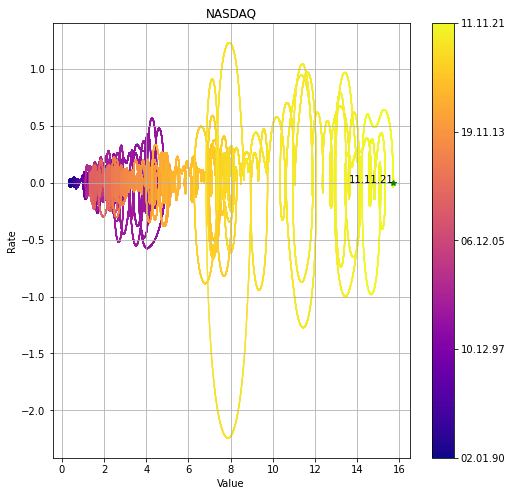

In [31]:
cmap = plt.cm.plasma
norm = plt.Normalize(x.min(), x.max())

c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

fig, ax = plt.subplots()
ax.scatter(func, deriv[1], c=c_bar, s=0.05)
cax=ax.plot(func[-1], deriv[1][-1], '*g', markersize=6)
ax.annotate(df['date'].iloc[-1].strftime('%d.%m.%y'),  xy=(func[-1], deriv[1][-1]), color='black', ha="right")
ax.set_ylabel('Rate')
ax.set_xlabel('Value')

plt.title('NASDAQ')

fig.set_figheight(8)
fig.set_figwidth(8)

# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#              cax=cax, orientation='vertical')
# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=years, orientation='vertical')
ticks_num=5
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'], ticks_num)))

plt.grid()
# plt.show()
# plt.savefig('Nasdaq_30_12_96_to_22_11_06.png')

In [39]:
def plot_phase_portrait(x, xx, dates, deriv, tt, name, ticks_num=5, save_fig_name=''):
    cmap = plt.cm.plasma
    norm = plt.Normalize(x.min(), x.max())

    c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

    fig, ax = plt.subplots()
    ax.scatter(deriv[0], deriv[1], c=c_bar, s=0.05)
    cax=ax.plot(deriv[0][-1], deriv[1][-1], '*g', markersize=6)
    ax.annotate(dates.iloc[-1].strftime('%d.%m.%y'),  xy=(deriv[0][-1], deriv[1][-1]), color='black', ha="left", va="center")
    ax.set_ylabel('Rate')
    ax.set_xlabel('Value')

    plt.title(name)

    fig.set_figheight(8)
    fig.set_figwidth(8)
    
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
    cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'], ticks_num)))

    plt.grid()
    plt.show()
    if save_fig_name:
        plt.savefig(f"{save_fig_name}.png")

In [41]:
def get_filename(name, min_date, max_date, freq):
    return f"{name}_{min_date}_to_{max_date}_f_{freq}"
name='NASDAQ'
filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)
filename

'NASDAQ_02_01_90_to_11_11_21_f_7'

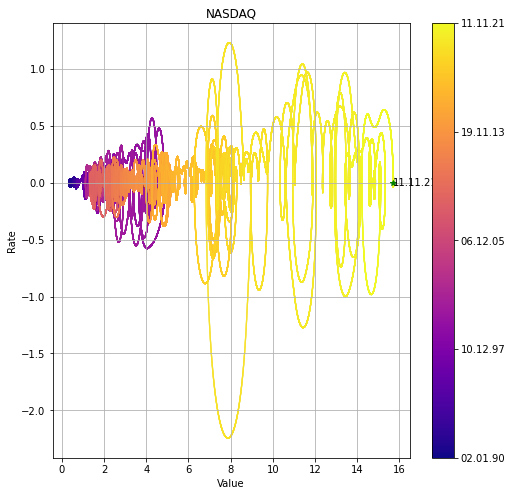

<Figure size 432x288 with 0 Axes>

In [42]:
plot_phase_portrait(x, xx, df['date'], deriv, tt, name, ticks_num=5, save_fig_name=filename)